In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import skorch
from skorch.helper import predefined_split
from skorch.dataset import Dataset

In [4]:
from functools import partial

In [5]:
import numpy as np

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [8]:
from deepspeech.model import DeepSpeech
from deepspeech.model import SequenceWise
from deepspeech.data.data_loader import SpectrogramParser
from deepspeech.data.data_loader import BucketingSampler

/home/nemo/envs/noswear/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [9]:
from data import dataset
from utils import RNNValueExtractor
from utils import Identity
from utils import bucketing_dataloader
from utils import filter_low_count_words
from layers import ResidualRNN

In [10]:
base_model = DeepSpeech.load_model(
    'models/librispeech_pretrained.pth'
)
audio_conf = DeepSpeech.get_audio_conf(base_model)
parser = SpectrogramParser(audio_conf)

In [11]:
ds_swear = dataset.SwearDataset(dataset.DEFAULT_PROVIDERS)

In [12]:
X_swear, y_swear = ds_swear.load()

In [13]:
ds = dataset.SwearBinaryAudioDataset(X_swear, y_swear, parser)

In [14]:
X, y = ds.load()

/home/nemo/envs/noswear/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=1
  n_fft, y.shape[-1]
/home/nemo/envs/noswear/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=320 is too small for input signal of length=2
  n_fft, y.shape[-1]


In [15]:
seq_lens = np.array([x.shape[0] for x in X])
max_seq_len = max(seq_lens)
max_seq_len, np.mean(seq_lens), np.median(seq_lens)

(161, 161.0, 161.0)

In [16]:
X_pad = np.zeros(
    (len(X), X[0].shape[0], max_seq_len), 
    dtype='float32'
)
for i, _ in enumerate(X):
    X_pad[i, :, :seq_lens[i]] = X[i]
    
y = np.array(y)

Filter low count words

In [17]:
idcs = filter_low_count_words(X_swear, min_count=4)
X_pad = X_pad[idcs]
y = y[idcs]

In [18]:
split = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [19]:
# use word as class for stratified split to make sure that train/test
# set both contain examples of the all words.
y_word = np.array([n[0] for n in X_swear])[idcs]
train_idcs_proto, test_idcs = next(split.split(y, y=y_word))

/home/nemo/envs/noswear/lib/python3.6/site-packages/scikit_learn-0.23.2-py3.6-linux-x86_64.egg/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [20]:
train_idcs, valid_idcs = next(split.split(y[train_idcs_proto], y=y_word[train_idcs_proto]))

/home/nemo/envs/noswear/lib/python3.6/site-packages/scikit_learn-0.23.2-py3.6-linux-x86_64.egg/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [21]:
train_idcs = train_idcs_proto[train_idcs]
valid_idcs = train_idcs_proto[valid_idcs]

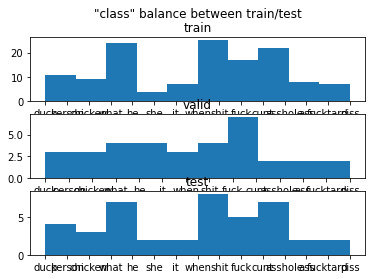

In [22]:
plt.subplot(311)
plt.title('"class" balance between train/test\ntrain')
plt.hist(y_word[train_idcs]);
plt.subplot(312)
plt.title('valid')
plt.hist(y_word[valid_idcs]);
plt.subplot(313)
plt.title('test')
plt.hist(y_word[test_idcs]);

In [23]:
X_train = {'lens': seq_lens[train_idcs], 'X': X_pad[train_idcs]}
y_train = np.array(y)[train_idcs]

X_valid = {'lens': seq_lens[valid_idcs], 'X': X_pad[valid_idcs]}
y_valid = np.array(y)[valid_idcs]

X_test = {'lens': seq_lens[test_idcs], 'X': X_pad[test_idcs]}
y_test = np.array(y)[test_idcs]

In [24]:
len(X_train['X']), len(X_valid['X']), len(X_test['X'])

(134, 34, 42)

In [25]:
class NoSwearModel(torch.nn.Module):
    def __init__(
        self, 
        base_model, 
        n_hidden=10, 
        n_layer=1,
        p_dropout=0.2
    ):
        super().__init__()
        self.base_model = base_model
        self.base_model.rnns = Identity()
        self.base_model.lookahead = Identity()
        self.base_model.fc = Identity()
        self.base_model.inference_softmax = Identity()
        
        self.rnn = torch.nn.Sequential(
            torch.nn.GRU(672, n_hidden, num_layers=n_layer, bias=False, batch_first=True),
            RNNValueExtractor(),
        )

        self.clf = torch.nn.Linear(n_hidden, 2, bias=False)
        self.dropout = torch.nn.Dropout(p=p_dropout)
        
    def forward(self, X, lens):
        # run base model, output is NxTxH with
        # T=Time, N=samples, H=hidden.
        y_pre = self.base_model(X)
        y_pre = self.dropout(y_pre)
        
        # run RNN over sequence and extract last item
        y = self.rnn(y_pre)
        # presumably we cannot use lens since cnns reduce that too
        #y = y[:, lens - 1]
        #y = y[:, -1]
        i = y.mean(-1).argmax(1)
        y = y[torch.arange(len(y)), i]
        
        y = self.dropout(y)
        
        # run classifier
        y = self.clf(y)
        y = torch.softmax(y, dim=-1)
        return y

In [26]:
def bucket(Xi, yi):
    Xi['X'] = Xi['X'][:, :, :max(Xi['lens'])]
    return Xi, yi

In [39]:
torch.manual_seed(42)

net = skorch.classifier.NeuralNetClassifier(
    partial(NoSwearModel, base_model), 
    
    iterator_train=bucketing_dataloader,
    iterator_train__bucket_fn=bucket,
    iterator_valid=bucketing_dataloader,
    iterator_valid__bucket_fn=bucket,
    
    batch_size=8,
    max_epochs=40,
    device='cuda',
    
    train_split=predefined_split(Dataset(X_valid, y_valid)),
    
    module__p_dropout=0.2,
    module__n_hidden=16,
        
    optimizer=torch.optim.Adam,
    optimizer__lr=0.02,
    
    callbacks=[
        skorch.callbacks.Freezer('base_model.*'),
        #skorch.callbacks.Checkpoint(monitor='valid_acc_best'),
        #skorch.callbacks.TrainEndCheckpoint(),
    ]
)

In [40]:
%pdb on
net.fit(X_train, y_train)

Automatic pdb calling has been turned ON


ValueError: Expected module output to have shape (n,) or (n, 1), got (8, 2) instead

> /home/nemo/Code/pytorch/skorch/skorch/classifier.py(305)infer()
    303             raise ValueError(
    304                 "Expected module output to have shape (n,) or "
--> 305                 "(n, 1), got {} instead".format(tuple(y_infer.shape)))
    306 
    307         y_infer = y_infer.reshape(-1)

ipdb> q


In [245]:
%pdb on
net.fit(X_train, y_train)

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        0.9890       0.5000        0.7355     +  0.2529
      2        0.7623       0.5263        0.7023     +  0.2549
      3        0.6927       0.5263        0.7195        0.2552
      4        0.6722       0.5000        0.7645        0.2544
      5        0.7062       0.5000        0.7878        0.2545
      6        0.6926       0.5000        0.7748        0.2544
      7        0.6867       0.5526        0.7576     +  0.2532
      8        0.7088       0.6053        0.7238     +  0.2532
      9        0.7010       0.6053        0.6981        0.2520
     10        0.6377       0.6053        0.6762        0.2544
     11        0.6497       0.6579        0.6661     +  0.2544
     12        0.6116       0.6842        0.6583     +  0.2566
     13        0.6287       0.6579        0.6600        0.2538
     14       

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=NoSwearModel(
    (base_model): DeepSpeech(
      (conv): Sequential(
        (0): Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(0, 10))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=0, max_val=20, inplace)
        (3): Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): Hardtanh(min_val=0, max_val=20, inplace)
      )
      (rnns): Identity()
      (fc): Identity()
      (inference_softmax): Identity()
      (lookahead): Identity()
    )
    (rnn): Sequential(
      (0): GRU(672, 300, bias=False, batch_first=True)
      (1): RNNValueExtractor()
    )
    (clf): Linear(in_features=300, out_features=2, bias=False)
    (dropout): Dropout(p=0.2)
  ),
)

In [249]:
#net.load_params(checkpoint=dict(net.callbacks_)['Checkpoint'])
#net.load_params(checkpoint=dict(net.callbacks_)['TrainEndCheckpoint'])

In [250]:
accuracy_score(y_test, net.predict(X_test))

0.7142857142857143

In [257]:
from sklearn.model_selection import GridSearchCV
from skorch.helper import SliceDict

In [258]:
#net.initialize();
net.set_params(verbose=False);

In [259]:
params = {
    'optimizer__lr': [0.02, 0.002, 0.0002],
    'optimizer__weight_decay': [0, 1e-4],
    'optimizer': [torch.optim.RMSprop, torch.optim.Adam],
    'module__p_dropout': [0, 0.5],
    'module__n_hidden': [10, 100, 200, 400],
    'module__n_layer': [1, 2],
}

In [ ]:
cv = TODO

In [260]:
gs = GridSearchCV(net, params, scoring='accuracy', cv=cv)

In [ ]:
%%time
gs.fit(SliceDict(**X_train), y_train);

In [264]:
gs

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=functools.partial(<class '__main__.NoSwearModel'>, DeepSpeech(
    (conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(0, 10))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1,...ax): Identity()
    (lookahead): Identity()
  )),
  module__n_hidden=300,
  module__p_dropout=0.2,
),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'optimizer__lr': [0.02, 0.002, 0.0002], 'module__n_layer': [1, 2], 'optimizer': [<class 'torch.optim.rmsprop.RMSprop'>, <class 'torch.optim.adam.Adam'>], 'optimizer__weight_decay': [0, 0.0001], 'module__n_hidden': [10, 100, 200, 400], 'module__p_dropout': [0, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [265]:
import pandas as pd
results = pd.DataFrame(gs.cv_results_)

In [282]:
top_results = results.sort_values(by='mean_test_score').head(10)

In [283]:
top_results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_module__n_hidden,param_module__n_layer,param_module__p_dropout,param_optimizer,param_optimizer__lr,param_optimizer__weight_decay,...,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
144,22.166183,0.159822,0.146341,0.666667,400,1,0,<class 'torch.optim.rmsprop.RMSprop'>,0.02,0,...,0.000000,0.780488,0.439024,0.500000,0.000000,0.719512,0.339894,0.017730,0.206958,0.120451
56,16.474293,0.131874,0.178862,0.898374,100,1,0,<class 'torch.optim.adam.Adam'>,0.002,0,...,0.000000,0.792683,0.414634,0.939024,0.121951,0.963415,0.112958,0.008257,0.173991,0.075395
97,18.050158,0.131793,0.203252,0.922764,200,1,0,<class 'torch.optim.rmsprop.RMSprop'>,0.02,0.0001,...,0.073171,0.975610,0.390244,0.841463,0.146341,0.951220,0.266049,0.002605,0.135556,0.058344
12,10.388777,0.089013,0.211382,0.703252,10,1,0.5,<class 'torch.optim.rmsprop.RMSprop'>,0.02,0,...,0.000000,0.780488,0.536585,0.487805,0.097561,0.841463,1.072718,0.012990,0.233377,0.154365
189,29.559384,0.185374,0.211382,0.865854,400,2,0.5,<class 'torch.optim.adam.Adam'>,0.002,0.0001,...,0.000000,0.792683,0.560976,0.804878,0.073171,1.000000,0.957089,0.010750,0.248998,0.094986
63,17.208370,0.147030,0.219512,0.861789,100,1,0.5,<class 'torch.optim.rmsprop.RMSprop'>,0.002,0.0001,...,0.000000,0.829268,0.487805,0.768293,0.170732,0.987805,0.424042,0.016235,0.202111,0.092519
101,18.502019,0.154078,0.219512,0.918699,200,1,0,<class 'torch.optim.rmsprop.RMSprop'>,0.0002,0.0001,...,0.097561,0.975610,0.512195,0.914634,0.048780,0.865854,0.414292,0.008792,0.207914,0.044900
55,16.482110,0.139156,0.219512,0.813008,100,1,0,<class 'torch.optim.adam.Adam'>,0.02,0.0001,...,0.121951,1.000000,0.487805,0.743902,0.048780,0.695122,0.092012,0.011236,0.192049,0.133715
79,17.353589,0.131291,0.219512,0.930894,100,2,0,<class 'torch.optim.adam.Adam'>,0.02,0.0001,...,0.048780,0.792683,0.439024,1.000000,0.170732,1.000000,0.599841,0.003257,0.163008,0.097730
26,16.399436,0.129530,0.227642,0.963415,10,2,0,<class 'torch.optim.rmsprop.RMSprop'>,0.002,0,...,0.024390,0.987805,0.390244,0.902439,0.268293,1.000000,0.167875,0.000289,0.152100,0.043403


In [284]:
top_results.params

144    {'optimizer__lr': 0.02, 'module__n_layer': 1, ...
56     {'optimizer__lr': 0.002, 'module__n_layer': 1,...
97     {'optimizer__lr': 0.02, 'module__n_layer': 1, ...
12     {'optimizer__lr': 0.02, 'module__n_layer': 1, ...
189    {'optimizer__lr': 0.002, 'module__n_layer': 2,...
63     {'optimizer__lr': 0.002, 'module__n_layer': 1,...
101    {'optimizer__lr': 0.0002, 'module__n_layer': 1...
55     {'optimizer__lr': 0.02, 'module__n_layer': 1, ...
79     {'optimizer__lr': 0.02, 'module__n_layer': 2, ...
26     {'optimizer__lr': 0.002, 'module__n_layer': 2,...
Name: params, dtype: object

In [286]:
net.set_params(verbose=True, **top_results.params.iloc[1]);

In [287]:
net.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1913       0.5263        0.7722  0.2194
      2        0.7487       0.5000        0.7050  0.2168
      3        0.6382       0.4737        0.7146  0.2119
      4        0.6410       0.4737        0.7574  0.2147
      5        0.6705       0.4737        0.7788  0.2137
      6        0.6884       0.4737        0.7601  0.2145
      7        0.6753       0.4474        0.7377  0.2140
      8        0.6573       0.4474        0.7066  0.2130
      9        0.6326       0.5000        0.6925  0.2161
     10        0.6150       0.5000        0.6870  0.2150
     11        0.6107       0.6053        0.6543  0.2144
     12        0.6004       0.6053        0.6482  0.2159
     13        0.5902       0.6316        0.6414  0.2104
     14        0.5829       0.6316        0.6312  0.2156
     15        0.5750       0.6579        0.6271  0.2150
     16        0.5628       0.6

In [288]:
accuracy_score(y_test, net.predict(X_test))

0.5102040816326531